In [14]:
from scipy import special
from scipy.optimize import brentq
from scipy.optimize import fixed_point
from scipy.interpolate import interp1d
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from ipywidgets import *
from IPython.display import display

In [104]:
class mdar():
    def __init__(self, M200=1e12, Mgal=0, Rh=0, f_mbulge=0.0, f_abulge=1.0, rmin=False, rmax=False):
        #define the constants
        self.M200    = M200
        self.hlittle = 0.7
        self.rhoc    = 2.775e2*self.hlittle**2
        self.G       = 4.299e-6
        self.Delta   = 200.0
        self.g_dag   = 1.2e-10
        mass_concentration = np.loadtxt('mass_concentration.txt')
        self.get_concentration = interp1d(10**(mass_concentration[:,0]+10-np.log10(self.hlittle)), 
                                          mass_concentration[:,1])
        halo_galaxy_relation = np.loadtxt('m200-mstr.txt')
        self.get_galaxy_mass = interp1d(halo_galaxy_relation[:,0], 
                                        halo_galaxy_relation[:,1]*halo_galaxy_relation[:,0])
        
      
        if(Mgal == 0):
            self.Mgal    = self.get_galaxy_mass(self.M200)
        else:
            self.Mgal    = Mgal
        if(Rh == 0):
            self.Rh    = self.get_disk_size()
            self.Rd    = self.Rh/1.678
        else:
            Self.Rh    = Rh
            self.Rd    = self.Rh/1.678
        
        
        self.f_mbulge = f_mbulge
        self.f_abulge = f_abulge*self.Rh
                
        self.rmin = rmin
        self.rmax = rmax
        
        self.r = self.set_extent()
        
    def set_extent(self):
        if(self.rmin):
            self.rmin = self.rmin
        else:
            self.rmin = 0.2*self.Rh
        if(self.rmax):
            self.rmax = self.rmax
        else:
            self.rmax = 5*self.Rh
            
        return 10**np.linspace(np.log10(self.rmin), np.log10(self.rmax), 100)
        
    def set_new_paramters(self,M200=1e12, Mgal=False, Rh=False, 
                          rmin=False, rmax=False, f_abulge=1.0, f_mbulge=0.0):
        self.M200 = M200
        if(Mgal == 0):
            self.Mgal    = self.get_galaxy_mass(self.M200)
        else:
            self.Mgal    = Mgal
        if(Rh == 0):
            self.Rh    = self.get_disk_size()
            self.Rd    = self.Rh/1.678
        else:
            self.Rh    = Rh
            self.Rd    = self.Rh/1.678
            
        self.f_mbulge = f_mbulge
        self.f_abulge = f_abulge*self.Rh            
            
        self.rmin = rmin
        self.rmax = rmax
        self.r = self.set_extent()
        return
        
    def get_halo_mass(self,r):
        c = self.get_concentration(self.M200)
        print c
        R200 = (self.M200/(self.Delta*self.rhoc*4./3.*np.pi))**(1./3.)
        RR = r/R200
        M = (np.log(1+c*RR)-c*RR/(1+c*RR))/(np.log(1.0+c)-c/(1.0+c))
        return M*self.M200
    
    def get_disk_size(self):
        R200 = (self.M200/(200*self.rhoc*4./3.*np.pi))**(1./3.)
        c    = self.get_concentration(self.M200)
        rs = R200/c
        return 0.2*rs    

    def McGaugh(self, gbar):
        return gbar/(1.0-np.exp(-np.sqrt(gbar/self.g_dag)))

    def get_vcirc_disk(self,r):
        sigma0 = (self.Mgal*(1.0-self.f_mbulge))/(2.0*np.pi*self.Rd**2)
        sigma  = sigma0*np.exp(-r/self.Rd)
        y = r/(2.0*self.Rd)
        I0 = special.i0(y)
        K0 = special.k0(y)
        I1 = special.i1(y)
        K1 = special.k1(y)
        return np.sqrt(4.0*np.pi*self.G*sigma0*self.Rd*y**2*(I0*K0-I1*K1))

    def get_vcirc_halo(self,r):
        return np.sqrt(self.G*self.get_halo_mass(r)/r)
    
    
    def get_vcirc_bulge(self,r):
        return np.sqrt(self.G*self.Mgal*self.f_mbulge*r/(r+self.f_abulge)**2/r)

    
    def get_disk_acc(self,r):
        gbar = (self.get_vcirc_disk(r)**2+self.get_vcirc_bulge(r)**2)/r*1e6/3.086e19
        return gbar
    
    def get_halo_acc(self,r):
        gdm = (self.G*self.get_halo_mass(r)/r)/r*1e6/(3.086e19)
        return gdm
        
    def plot_mdar(self, ax=None):
        gg = np.linspace(-13,-7)
        if(ax == None):
            ax = plt.gca()
        ax.plot(gg, gg, ls='--')
        ax.plot(gg, np.log10(self.McGaugh(10**gg)), ls='--')
        
    def plot_galaxy(self, ax=None):
        if(ax == None):
            ax = plt.gca()
        gbar = self.get_disk_acc(self.r)
        gdm  = self.get_halo_acc(self.r)        
        ax.plot(np.log10(gbar), np.log10(gbar+gdm))
    
    def plot_vcirc(self, ax=None):
        vcirc_disk  = self.get_vcirc_disk(self.r)
        vcirc_halo  = self.get_vcirc_halo(self.r)
        vcirc_bulge = self.get_vcirc_bulge(self.r)
        total = np.sqrt(vcirc_disk**2+vcirc_halo**2+vcirc_bulge**2)
        
        if(ax == None):
            ax = plt.gca()
        ax.plot(self.r, vcirc_disk, label='disk')
        ax.plot(self.r, vcirc_halo, label='dm halo')
        ax.plot(self.r, vcirc_bulge, label='bulge')
        ax.plot(self.r, total, label='total')
    

In [105]:
def plot_function(M200, Mgal, Rh, f_mbulge, f_abulge):
    fig = plt.figure(1,figsize=(10,5))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    
    if(Mgal == 0):
        Mgal == 0
    else:
        Mgal = 10**Mgal
    
    a.set_new_paramters(M200=10**M200, f_mbulge=f_mbulge, f_abulge=f_abulge, Mgal=Mgal, Rh=Rh)
    a.plot_mdar(ax=ax1)    
    a.plot_galaxy(ax=ax1)
    ax1.set_xlim(-13,-7)
    ax1.set_ylim(-13,-7)
    
    a.plot_vcirc(ax=ax2)
    ax2.legend(loc='upper left')
    return

#def on_button_clicked(b):

a = mdar()

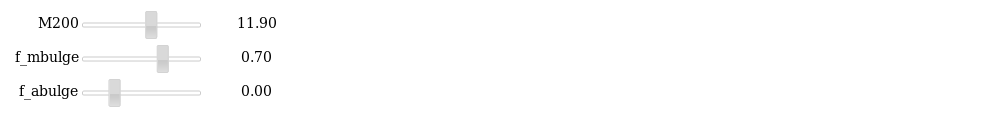

10.9247506828
10.9247506828


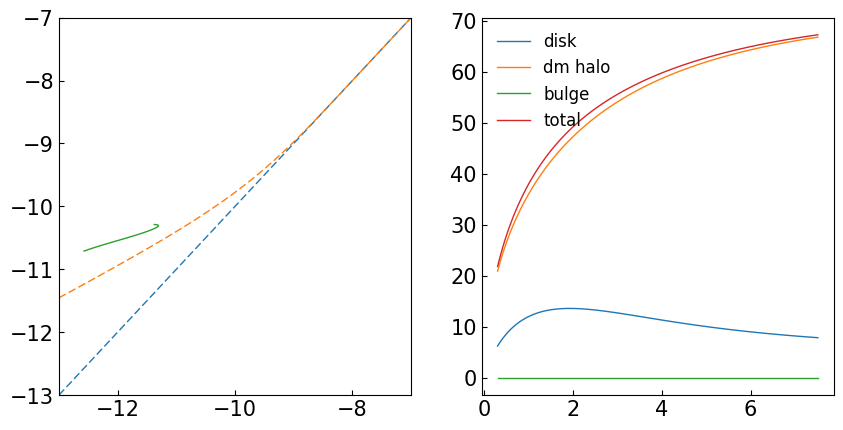

In [107]:
slider_Mgal = FloatSlider(min=0,max=16.0, setep=1, value=0)
slider_Rh   = FloatSlider(min=0,max=20.0, setep=1, value=0)
slider_m200 = FloatSlider(min=10.3,max=15.0, setep=1, value=12)
slider_fmbulge = FloatSlider(min=0,max=1.0, setep=0.01, value=0.0)
slider_fabulge = FloatSlider(min=0,max=2.0, setep=0.01, value=0.5)

button = widgets.Button(description="Plot!")

interact(plot_function, M200=slider_m200, Mgal=slider_Mgal, Rh=slider_Rh,
         f_mbulge=slider_fmbulge, f_abulge=slider_fabulge);
